# Tema: Datasets Desbalanceados

## Partes:
1. `Datasets Sintéticos`
2. `Entrenamiento Modelo Uno: Datos desbalanceados`
3. `Balanceando el Dataset`
4. `Entrenamiento Modelo Dos: Datos balanceados`
5. `Dataset de Fraude`

---

## 1. Datasets Sintéticos

Vamos a comenzar generando un `dataset sintético`. La ventaja de este enfoque es que podemos controlar muchas características de este dataset. Por ejemplo, la cantidad de features, si hay features correlacionados o no, la separación entre clases, el desbalanceo, etc.

Vamos a comenzar generando un dataset, que luego separaremos en un dataset `medido` y en un dataset `no medido`. De esta forma, simulamos (de una manera muy inocente) el proceso de medición. Esto se podría hacer mejor: en este proceso de medición podríamos agregar ruido, valores mal medidos, etiquetas intercambiadas, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.datasets import make_classification

La siguiente celda genera los datos con los que vamos a trabajar. Para más información de `make_classification` ir a su [Documentación de Sklearn.](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [2]:
X_real, y_real = make_classification(n_samples=100000,n_features=4, n_informative=4,
                                     n_redundant=0, n_clusters_per_class=1,
                                     class_sep=1.0, weights = [0.99], random_state=40)

Y miramos la cantidad de instancias con etiqueta positiva y qué porcentaje del dataset representa.

In [3]:
print("Tamaño total dataset: "+str(y_real.size))
print("Instancias POSITIVAS: "+str(y_real.sum()))
print("Relación POS/TOTAL:   "+str(y_real.sum()/y_real.size))

Tamaño total dataset: 100000
Instancias POSITIVAS: 1470
Relación POS/TOTAL:   0.0147


Pasamos a un DataFrame de Pandas para poder aprovechar algunas funcionalidades de la librería.

In [4]:
df_real = pd.DataFrame()

In [5]:
for i in range(X_real.shape[1]):
    df_real['x' + str(i)] = X_real[:,i]
df_real['y'] = y_real  
df_real.head()

,x0,x1,x2,x3,y
0,3.976821,0.372961,-0.650739,2.073284,0
1,1.629085,-1.059597,-1.654043,0.431430,0
2,1.178563,-0.250376,2.329269,1.370564,0
3,1.093868,-1.616160,1.727165,1.464183,0
4,-0.652038,-2.527268,1.589253,1.248053,0


Como ya viene mezclado al azar, seleccionar las diez mil primeras instancias es equivalente a muestrear al azar el dataset original.

In [6]:
N = 10000
df_medido = df_real[:N]
df_medido.head()

,x0,x1,x2,x3,y
0,3.976821,0.372961,-0.650739,2.073284,0
1,1.629085,-1.059597,-1.654043,0.431430,0
2,1.178563,-0.250376,2.329269,1.370564,0
3,1.093868,-1.616160,1.727165,1.464183,0
4,-0.652038,-2.527268,1.589253,1.248053,0


Y dejamos el resto de los los datos como instancias `no medidas`

In [7]:
df_no_medido = df_real[N:].reset_index(drop = True)
df_no_medido.head()

,x0,x1,x2,x3,y
0,0.482545,-0.448791,-0.812647,0.595696,0
1,5.544468,-1.917801,0.870708,3.020132,0
2,2.154670,-1.124450,0.215696,1.889750,0
3,2.290953,-0.976496,0.518059,1.531779,0
4,3.191610,-0.883649,1.206954,2.068909,0


¿Cuántas instancias positivas y qué porcentaje hay en cada dataset?

In [8]:
print("DATASET MEDIDO:")
print("Instancias POSITIVAS: "+str(df_medido.y.sum()))
print("Relación POS/TOTAL:   "+str(df_medido.y.sum()/df_medido.size))

print("\nDATASET NO MEDIDO:")
print("Instancias POSITIVAS: "+str(df_no_medido.y.sum()))
print("Relación POS/TOTAL:   "+str(df_no_medido.y.sum()/df_no_medido.size))

DATASET MEDIDO:
Instancias POSITIVAS: 162
Relación POS/TOTAL:   0.00324

DATASET NO MEDIDO:
Instancias POSITIVAS: 1308
Relación POS/TOTAL:   0.0029066666666666668


### Exploración de los datos

Miremos cómo es el dataset con el que vamos a trabajar, `df_medido`.

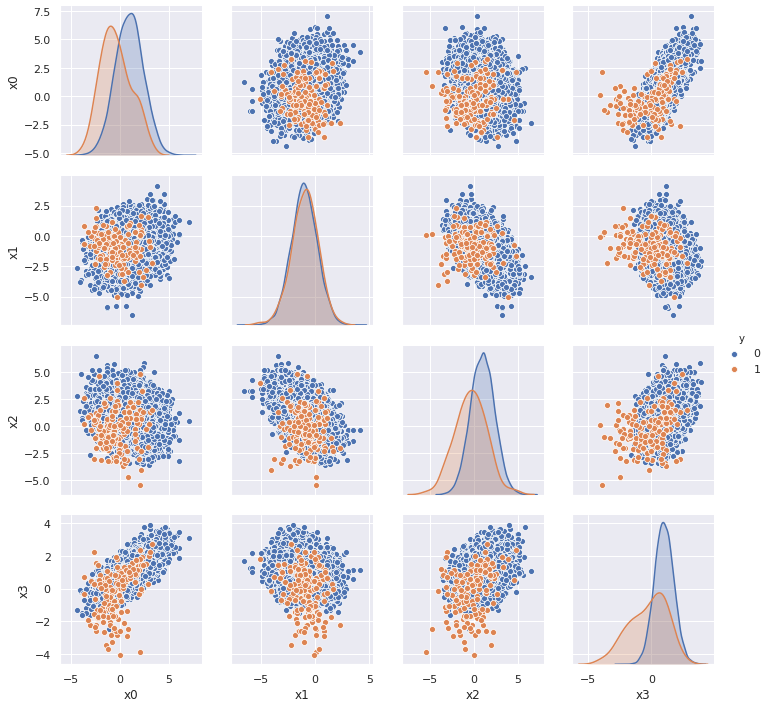

In [9]:
sns.pairplot(data = df_medido, vars = df_medido.columns[:-1], hue = 'y');

Y cómo queda la tabla de correlaciones.

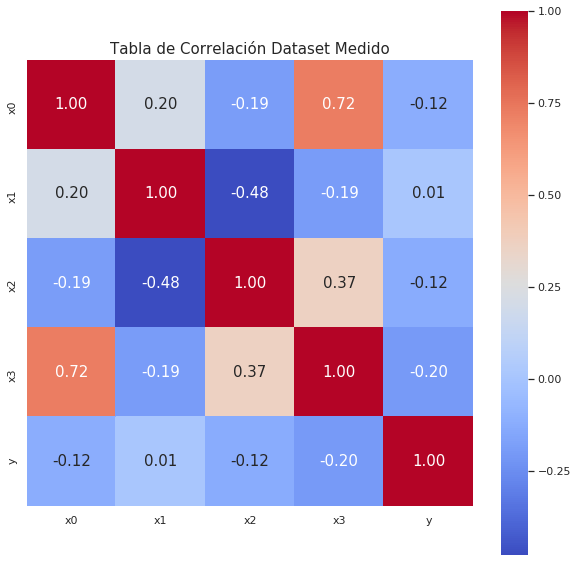

In [10]:
corr = df_medido.corr('pearson')
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_medido.columns, 
           yticklabels= df_medido.columns,
           cmap= 'coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.title("Tabla de Correlación Dataset Medido", fontsize=15)
plt.savefig('Correlacion_Dataset_MEDIDO_Desbalanceado.png')

¿Cuáles atributos serán buenos predictores?

`Ejercicio: Familiarizarse con la función que genera los datos. Cambiar algunos de sus parámetros y volver a correr.`

**Para pensar**: ¿Qué pasa con la tabla de correlaciones a medida que la prevalencia de la clase positiva disminuye?

---
## 2. Entrenamiento Modelo Uno

Vamos a entrenar un primer modelo de `árbol de decisión` y evaluarlo usando exactitud. Para ello:

Seleccionamos variables predictoras y etiquetas

In [11]:
X = df_medido.drop('y', axis = 1).values
y = df_medido.y.values

Hacemos un `train_test_split`

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

Observamos cómo son las distribuciones de las variables predictoras

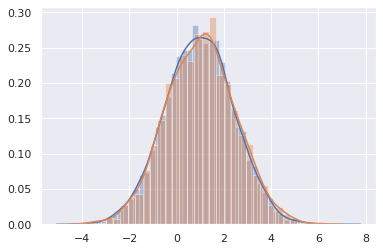

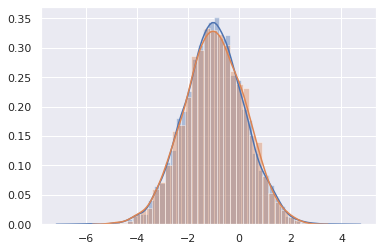

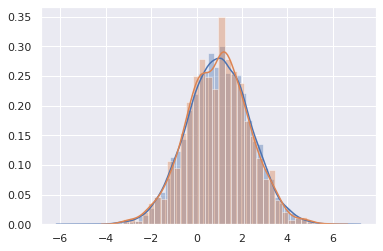

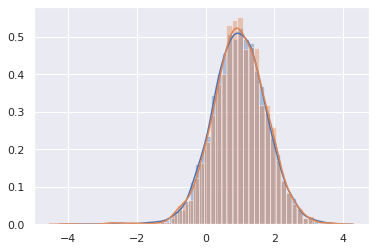

In [13]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [14]:
print('Proporcion de etiquetas POSITIVAS en los datos de TRAIN: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas POSITIVAS en los datos de TEST:  ', y_test.sum()/y_test.size) 

Proporcion de etiquetas POSITIVAS en los datos de TRAIN:  0.01625
Proporcion de etiquetas POSITIVAS en los datos de TEST:   0.016


### Entrenamiento del modelo

Vamos a hacer una `curva de validación` para elegir la mejor profundidad para el árbol de decisión. 

In [15]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [16]:
from sklearn.model_selection import cross_validate

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

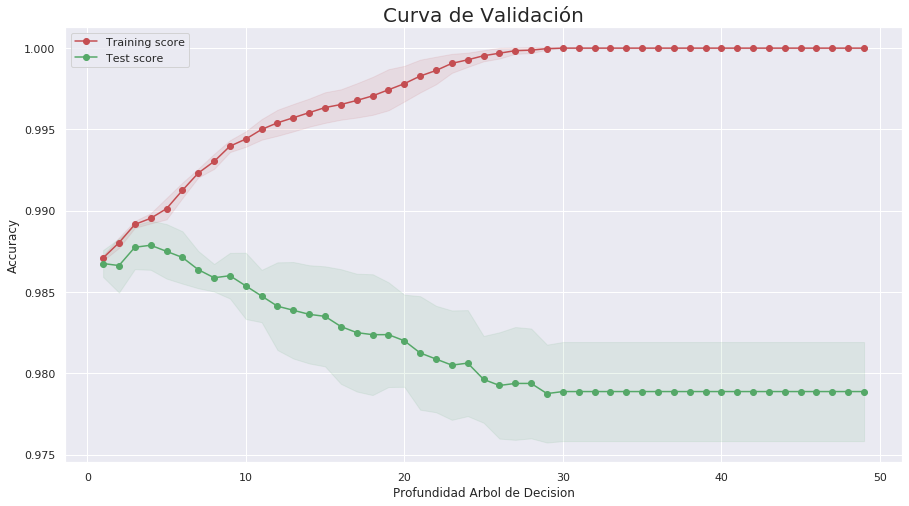

In [17]:
plt.figure(figsize=(15,8))
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.title("Curva de Validación", fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profundidad usarían? ¿Cuál es el *benchmark* de este problema?

`Nota: Benchmark hace referencia a predecir a todas las categorías como NEGATIVAS`

Entrenemos un árbol de profundidad `3` y evaluémoslo en el conjunto de TEST.

In [18]:
clf_1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [19]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_1.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_1.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de TRAIN:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de TEST: ', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de TRAIN: 0.989125
Accuracy sobre conjunto de TEST:  0.9875


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[7867,    3],
       [  84,   46]])

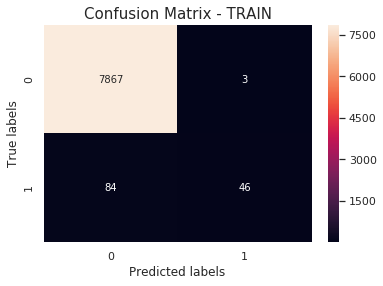

In [21]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - TRAIN', fontsize=15); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [22]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[1966,    2],
       [  23,    9]])

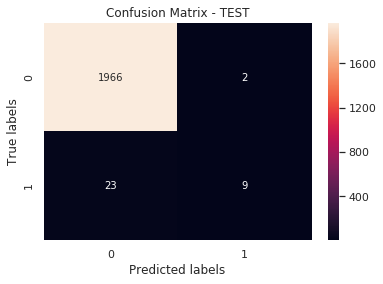

In [23]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - TEST'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? En el caso de un examen médico, ¿un FP tiene el mismo costo que un FN?

`Ejercicio: calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de TEST. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.`

`Ayuda:` La función `classification_report` les puede servir para ésta tarea, pero no es la única forma de hacerlo. 

### ¿Y si lo ponemos "en producción"?

Una de las ventajas de trabajar con datos sintéticos es que podemos ver cómo desempeñaría nuestro modelo si lo ponemos en producción.

In [24]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [25]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_1.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre dataset NO MEDIDO:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre dataset NO MEDIDO: 0.9887111111111111


In [26]:
cm = confusion_matrix(y_no_medido, y_no_medido_pred)
cm

array([[88556,   136],
       [  880,   428]])

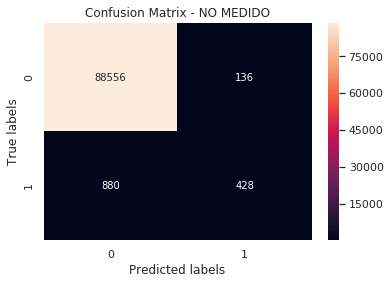

In [27]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - NO MEDIDO'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

`Ejercicio: medir precisión, exhaustividad y F-Score`

`Ejercicio: repetir para un modelo de vecinos más cercanos`

---
## 3. Balanceando el Dataset

Vamos a balancear el dataset subsampleando la clase más prevalente. Luego, volvemos a analizar los datos y entrenar los modelos.

In [28]:
mask = df_medido.y == 1
df_subsample = pd.concat([df_medido[mask], df_medido[~mask].sample(n = mask.sum())])
#print(len(df_medido[mask]))
#print(len(df_medido[~mask]))
#print(len(df_medido[~mask].sample(n = mask.sum())))
#print(len(df_subsample))

In [29]:
df_subsample = df_subsample.sample(frac=1, random_state=42).reset_index(drop=True)

Hacemos el `pairplot`

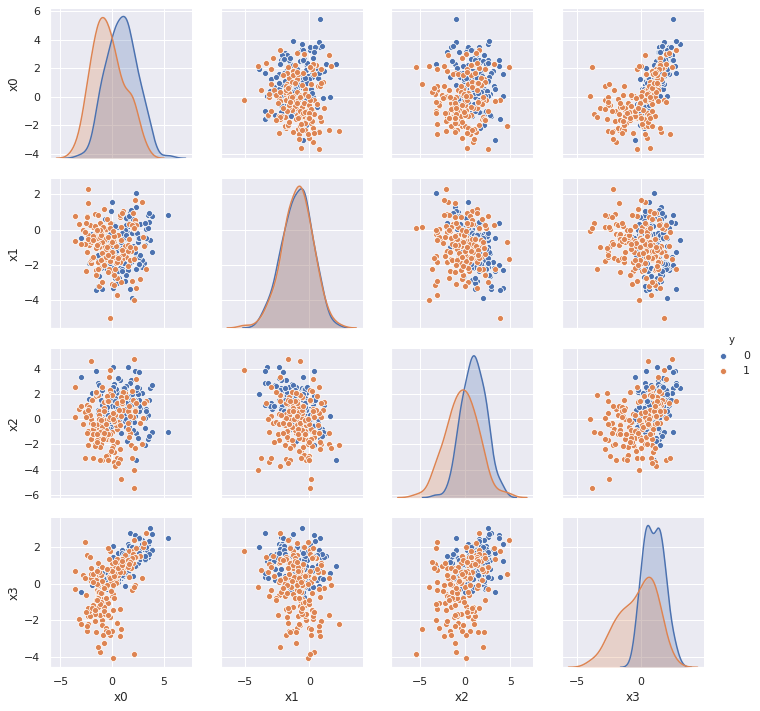

In [30]:
sns.pairplot(data = df_subsample, vars = df_subsample.columns[:-1], hue = 'y');

Y la tabla de correlaciones.

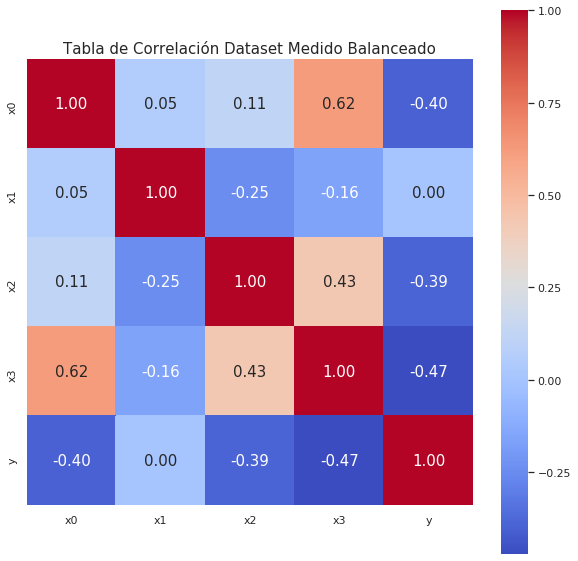

In [31]:
corr = df_subsample.corr('pearson')
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_subsample.columns, 
           yticklabels= df_subsample.columns,
           cmap= 'coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.title("Tabla de Correlación Dataset Medido Balanceado", fontsize=15)
plt.savefig('Correlacion_Dataset_MEDIDO_Balanceado.png')

¿Notan algo diferente en la tabla con respecto a la anterior? Si quieren, copien la celda de código de la tabla anterior para poder verlas juntas.

`Nota:` El código guarda las imagenes de las correlaciones en dos archivos diferentes.

---
## 4. Entrenamiento Modelo Dos

Seleccionamos variables predictoras y etiquetas. Recordar que estamos trabajando con el dataset balanceado.

In [32]:
X = df_subsample.drop('y', axis = 1).values
y = df_subsample.y.values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

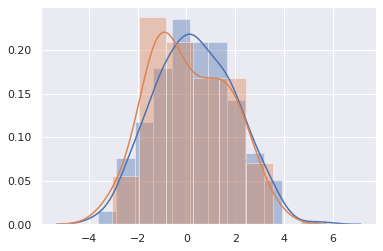

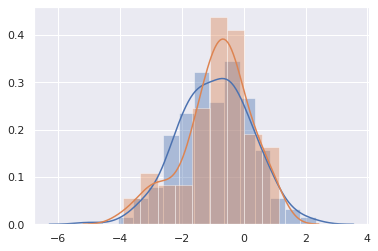

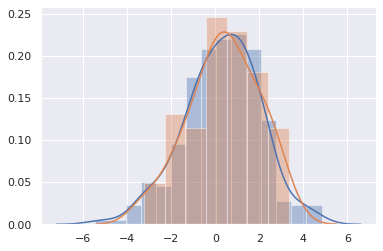

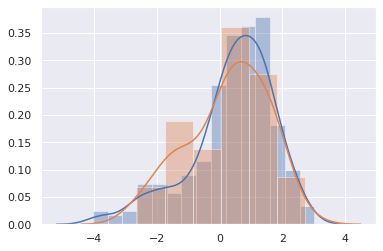

In [34]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [35]:
print('Proporcion de etiquetas POSITIVAS en los datos de TRAIN: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas POSITIVAS en los datos de TEST:  ', y_test.sum()/y_test.size)

Proporcion de etiquetas POSITIVAS en los datos de TRAIN:  0.4980694980694981
Proporcion de etiquetas POSITIVAS en los datos de TEST:   0.5076923076923077


### Entrenamiento del modelo

Volvemos a hacer la curva de validación.

In [36]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

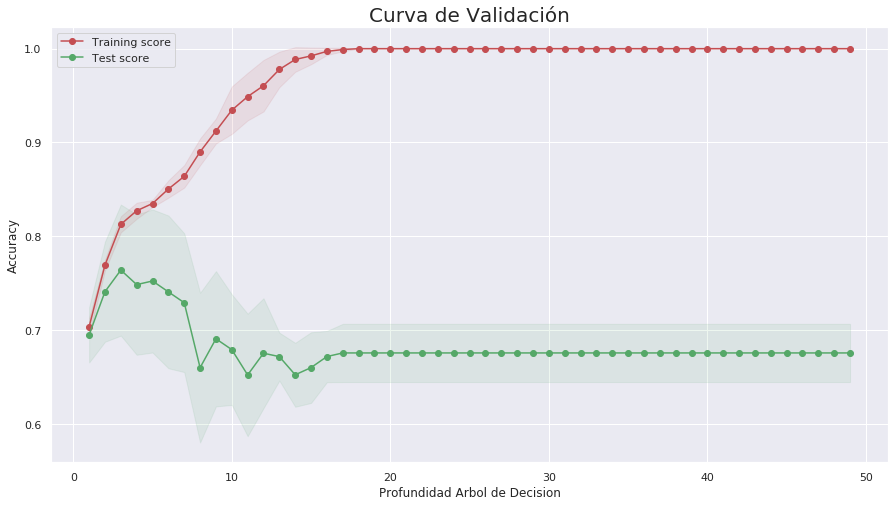

In [37]:
plt.figure(figsize=(15,8))
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.title("Curva de Validación", fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profunidad usarían? Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad `3` y evaluémoslo en el conjunto de test.

In [38]:
clf_2 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [39]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_2.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_2.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de TRAIN:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de TEST: ', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de TRAIN: 0.8108108108108109
Accuracy sobre conjunto de TEST:  0.7538461538461538


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [40]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[127,   3],
       [ 46,  83]])

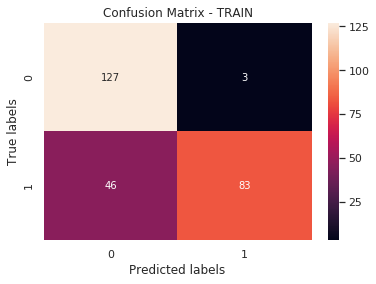

In [41]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - TRAIN'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [42]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[29,  3],
       [13, 20]])

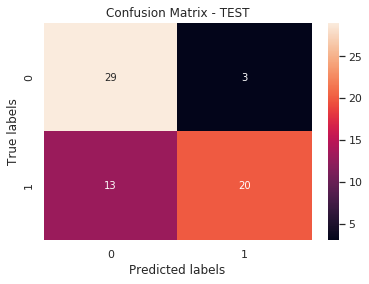

In [43]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - TEST'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? 

`Ejercicio: Igual que antes. Calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn`

`Ayuda:` La función `classification_report` les puede servir para ésta tarea, pero no es la única forma de hacerlo. 

### ¿Y si lo ponemos "en producción"?

In [44]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [45]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_2.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre dataset NO MEDIDO:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre dataset NO MEDIDO: 0.9022555555555556


In [46]:
cm = confusion_matrix(y_no_medido, y_no_medido_pred)
cm

array([[80396,  8296],
       [  501,   807]])

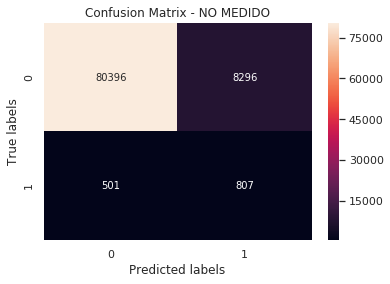

In [47]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - NO MEDIDO'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

¿Qué cambió? ¿Es mejor o peor este modelo que el anterior árbol de decisión?

`Ejercicio: medir precisión, exhaustividad y F-Score`

`Ejercicio: repetir para un modelo de vecinos más cercanos`

---
## 5. Dataset de Fraude

Los invitamos a trabajar con este dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

Pueden encontrar un link a un lindo análisis en la presentación de la clase de hoy.